# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [ ]:
########### Basic Parameters for Running: ################################
    
TFlite_Version  = "1210"   
TFlite_MainType = "ana-cont"
TFlite_Size     = "s3_long"
Training_Percentage = 0.05              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(7684, 32, 32, 3)
(7684, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(inputs3)
inputs5 = tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(64,activation="relu")(inputs9)
inputs11 = tf.keras.layers.Dense(32,activation="relu")(inputs10)
output = tf.keras.layers.Dense(2)(inputs11)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

#model = Sequential()
#model.add(BatchNormalization(input_shape=(32,32,3)))
#model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(16, (5, 5), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(64,activation="relu"))
#model.add(Dense(32,activation="relu"))
#model.add(Dense(2))

#model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

#model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          12816     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0     

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 100
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/100


C:\Users\Muell\AppData\Local\Temp\ipykernel_10080\65716224.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


961/961 [==============================] - 6s 6ms/step - loss: 0.1860 - accuracy: 0.8393 - val_loss: 0.0635 - val_accuracy: 0.9299
Epoch 2/100
961/961 [==============================] - 5s 6ms/step - loss: 0.0568 - accuracy: 0.9383 - val_loss: 0.0466 - val_accuracy: 0.9351
Epoch 3/100
961/961 [==============================] - 5s 6ms/step - loss: 0.0377 - accuracy: 0.9504 - val_loss: 0.0497 - val_accuracy: 0.9403
Epoch 4/100
961/961 [==============================] - 5s 6ms/step - loss: 0.0299 - accuracy: 0.9563 - val_loss: 0.0306 - val_accuracy: 0.9377
Epoch 5/100
961/961 [==============================] - 5s 6ms/step - loss: 0.0239 - accuracy: 0.9610 - val_loss: 0.0306 - val_accuracy: 0.9506
Epoch 6/100
961/961 [==============================] - 5s 6ms/step - loss: 0.0192 - accuracy: 0.9668 - val_loss: 0.0158 - val_accuracy: 0.9714
Epoch 7/100
961/961 [==============================] - 5s 6ms/step - loss: 0.0150 - accuracy: 0.9693 - val_loss: 0.0276 - val_accuracy: 0.9610
Epoch 8/100

### Step 1: Learing result
 
* Visualization of the training and validation results

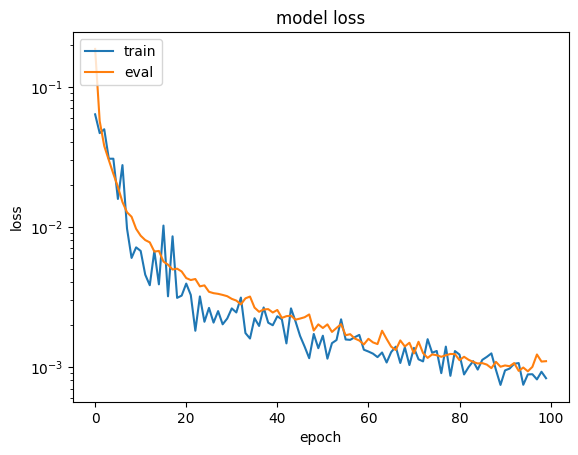

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 600
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/600
 24/961 [..............................] - ETA: 6s - loss: 0.3970 - accuracy: 0.7292

C:\Users\Muell\AppData\Local\Temp\ipykernel_10080\3747815558.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


961/961 [==============================] - 7s 7ms/step - loss: 0.1184 - accuracy: 0.8894 - val_loss: 0.0715 - val_accuracy: 0.8935
Epoch 2/600
961/961 [==============================] - 6s 7ms/step - loss: 0.0550 - accuracy: 0.9373 - val_loss: 0.0505 - val_accuracy: 0.9532
Epoch 3/600
961/961 [==============================] - 6s 7ms/step - loss: 0.0416 - accuracy: 0.9464 - val_loss: 0.0353 - val_accuracy: 0.9221
Epoch 4/600
961/961 [==============================] - 6s 7ms/step - loss: 0.0354 - accuracy: 0.9535 - val_loss: 0.0299 - val_accuracy: 0.9558
Epoch 5/600
961/961 [==============================] - 6s 7ms/step - loss: 0.0299 - accuracy: 0.9555 - val_loss: 0.0260 - val_accuracy: 0.9506
Epoch 6/600
961/961 [==============================] - 6s 6ms/step - loss: 0.0257 - accuracy: 0.9595 - val_loss: 0.0236 - val_accuracy: 0.9506
Epoch 7/600
961/961 [==============================] - 7s 7ms/step - loss: 0.0221 - accuracy: 0.9621 - val_loss: 0.0211 - val_accuracy: 0.9532
Epoch 8/600

721/721 [==============================] - 9s 13ms/step - loss: 5.0155e-04 - accuracy: 0.9962 - val_loss: 4.6241e-04 - val_accuracy: 0.9974
Epoch 163/600
721/721 [==============================] - 10s 13ms/step - loss: 5.0047e-04 - accuracy: 0.9970 - val_loss: 4.9512e-04 - val_accuracy: 0.9991
Epoch 164/600
721/721 [==============================] - 9s 13ms/step - loss: 4.7911e-04 - accuracy: 0.9958 - val_loss: 4.8826e-04 - val_accuracy: 0.9887
Epoch 165/600
721/721 [==============================] - 9s 13ms/step - loss: 5.0449e-04 - accuracy: 0.9953 - val_loss: 4.9133e-04 - val_accuracy: 0.9931
Epoch 166/600
721/721 [==============================] - 9s 13ms/step - loss: 4.9675e-04 - accuracy: 0.9962 - val_loss: 5.1841e-04 - val_accuracy: 0.9957
Epoch 167/600
721/721 [==============================] - 9s 12ms/step - loss: 5.0528e-04 - accuracy: 0.9965 - val_loss: 5.4107e-04 - val_accuracy: 0.9913
Epoch 168/600
721/721 [==============================] - 9s 13ms/step - loss: 4.8258e-04 

721/721 [==============================] - 9s 13ms/step - loss: 3.8756e-04 - accuracy: 0.9958 - val_loss: 3.8555e-04 - val_accuracy: 0.9983
Epoch 269/600
721/721 [==============================] - 9s 13ms/step - loss: 3.9617e-04 - accuracy: 0.9958 - val_loss: 3.5900e-04 - val_accuracy: 0.9957
Epoch 270/600
721/721 [==============================] - 9s 13ms/step - loss: 3.9981e-04 - accuracy: 0.9951 - val_loss: 3.8510e-04 - val_accuracy: 0.9965
Epoch 271/600
721/721 [==============================] - 9s 13ms/step - loss: 3.7818e-04 - accuracy: 0.9967 - val_loss: 3.4793e-04 - val_accuracy: 0.9983
Epoch 272/600
721/721 [==============================] - 9s 13ms/step - loss: 3.8851e-04 - accuracy: 0.9969 - val_loss: 3.5742e-04 - val_accuracy: 0.9913
Epoch 273/600
721/721 [==============================] - 9s 13ms/step - loss: 3.9432e-04 - accuracy: 0.9960 - val_loss: 4.2198e-04 - val_accuracy: 0.9939
Epoch 274/600
721/721 [==============================] - 9s 12ms/step - loss: 3.8020e-04 -

721/721 [==============================] - 9s 12ms/step - loss: 3.3457e-04 - accuracy: 0.9979 - val_loss: 2.8276e-04 - val_accuracy: 0.9974
Epoch 375/600
721/721 [==============================] - 9s 13ms/step - loss: 3.4083e-04 - accuracy: 0.9967 - val_loss: 2.8647e-04 - val_accuracy: 0.9965
Epoch 376/600
721/721 [==============================] - 9s 13ms/step - loss: 3.2627e-04 - accuracy: 0.9967 - val_loss: 3.3350e-04 - val_accuracy: 0.9965
Epoch 377/600
721/721 [==============================] - 9s 13ms/step - loss: 3.2368e-04 - accuracy: 0.9972 - val_loss: 3.7978e-04 - val_accuracy: 0.9957
Epoch 378/600
721/721 [==============================] - 9s 13ms/step - loss: 3.3972e-04 - accuracy: 0.9969 - val_loss: 3.4141e-04 - val_accuracy: 0.9991
Epoch 379/600
721/721 [==============================] - 9s 12ms/step - loss: 3.4301e-04 - accuracy: 0.9958 - val_loss: 3.0835e-04 - val_accuracy: 0.9983
Epoch 380/600
721/721 [==============================] - 9s 13ms/step - loss: 3.3459e-04 -

721/721 [==============================] - 9s 13ms/step - loss: 3.0061e-04 - accuracy: 0.9981 - val_loss: 2.9628e-04 - val_accuracy: 0.9983
Epoch 481/600
721/721 [==============================] - 9s 12ms/step - loss: 2.9393e-04 - accuracy: 0.9979 - val_loss: 3.5981e-04 - val_accuracy: 0.9957
Epoch 482/600
721/721 [==============================] - 9s 13ms/step - loss: 2.9896e-04 - accuracy: 0.9967 - val_loss: 2.6984e-04 - val_accuracy: 0.9974
Epoch 483/600
721/721 [==============================] - 9s 12ms/step - loss: 3.0930e-04 - accuracy: 0.9962 - val_loss: 3.3248e-04 - val_accuracy: 0.9983
Epoch 484/600
721/721 [==============================] - 9s 13ms/step - loss: 3.1728e-04 - accuracy: 0.9972 - val_loss: 2.5831e-04 - val_accuracy: 0.9974
Epoch 485/600
721/721 [==============================] - 9s 12ms/step - loss: 3.2625e-04 - accuracy: 0.9988 - val_loss: 3.4847e-04 - val_accuracy: 0.9974
Epoch 486/600
721/721 [==============================] - 9s 13ms/step - loss: 3.0585e-04 -

721/721 [==============================] - 9s 13ms/step - loss: 2.8799e-04 - accuracy: 0.9986 - val_loss: 2.2895e-04 - val_accuracy: 0.9983
Epoch 587/600
721/721 [==============================] - 9s 12ms/step - loss: 2.7919e-04 - accuracy: 0.9983 - val_loss: 2.2559e-04 - val_accuracy: 0.9974
Epoch 588/600
721/721 [==============================] - 9s 13ms/step - loss: 2.7668e-04 - accuracy: 0.9984 - val_loss: 2.5792e-04 - val_accuracy: 0.9965
Epoch 589/600
721/721 [==============================] - 9s 12ms/step - loss: 2.8425e-04 - accuracy: 0.9970 - val_loss: 2.2672e-04 - val_accuracy: 0.9983
Epoch 590/600
721/721 [==============================] - 9s 13ms/step - loss: 2.7706e-04 - accuracy: 0.9981 - val_loss: 2.8228e-04 - val_accuracy: 0.9983
Epoch 591/600
721/721 [==============================] - 9s 13ms/step - loss: 2.8737e-04 - accuracy: 0.9976 - val_loss: 2.7261e-04 - val_accuracy: 0.9974
Epoch 592/600
721/721 [==============================] - 9s 12ms/step - loss: 2.9821e-04 -

### Overall Learing results (Step 1 & Step 2)

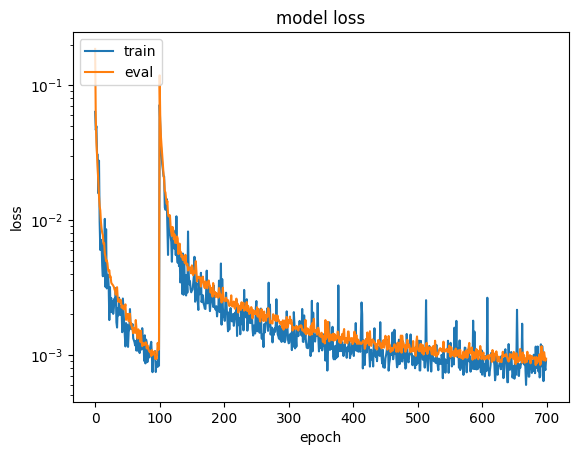

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img, verbose=0)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\0.0_759b6e62af23ccf905789eeb80c9f440.jpg 0.0 0.2879394690120767 -0.2879394690120767
data_resize_all\0.0_name_20230216-061847.jpg 0.0 -0.13498130042204004 0.13498130042204004
data_resize_all\0.0_name_20230216-062347.jpg 0.0 -0.053061406013862666 0.053061406013862666
data_resize_all\0.0_name_20230216-132347.jpg 0.0 -0.0931054865116826 0.0931054865116826
data_resize_all\0.0_name_20230216-191846.jpg 0.0 -0.0847970926232976 0.0847970926232976
data_resize_all\0.1_name_20230216-230846.jpg 0.01 -0.05114437112769088 0.06114437112769088
data_resize_all\0.2_0076_zeiger3_2020-04-29_14-38-02.jpg 0.02 -0.47125709801203375 0.49125709801203377
data_resize_all\0.2_71cb15f34eae196cb16f3d7ca457c337.jpg 0.02 0.26306122592471765 -0.24306122592471766
data_resize_all\0.2_b996a82eca0579959c32b800815d045b.jpg 0.02 0.2073705006443632 -0.1873705006443632
data_resize_all\0.2_name_20230216-192346.jpg 0.02 -0.04159301087641043 0.061593010876410434
data_resize_all\0.2_name_20230216-231346.jpg 0.02 -0

## Results

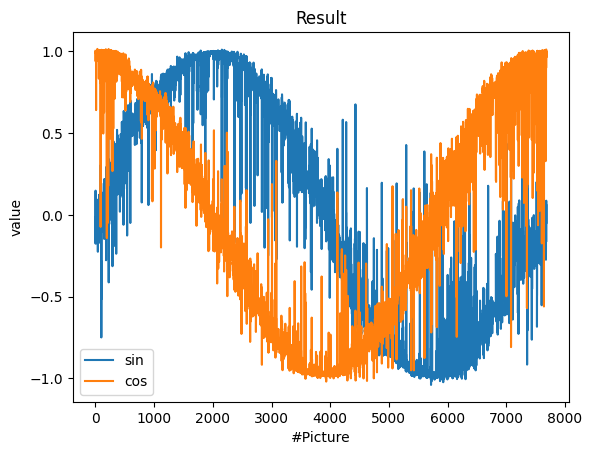

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

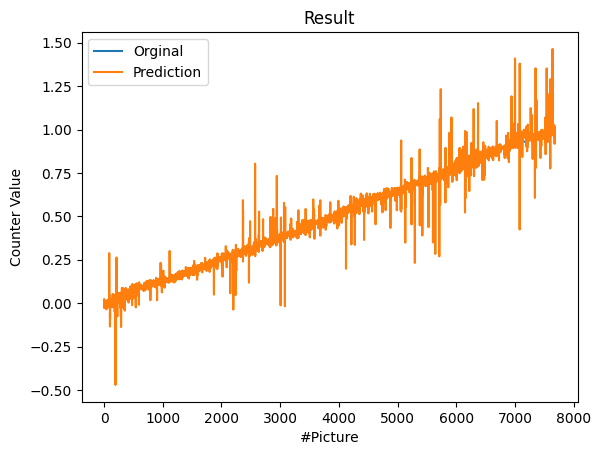

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

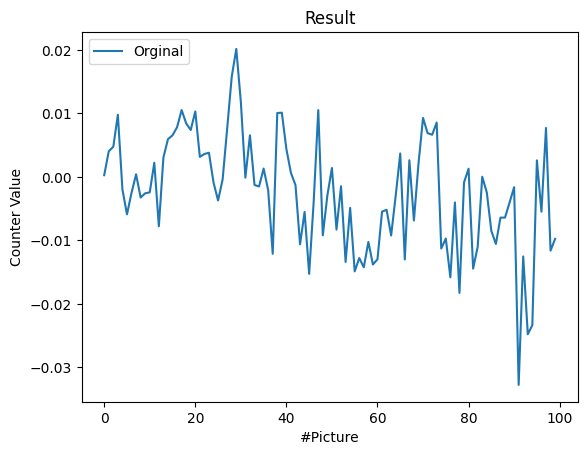

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

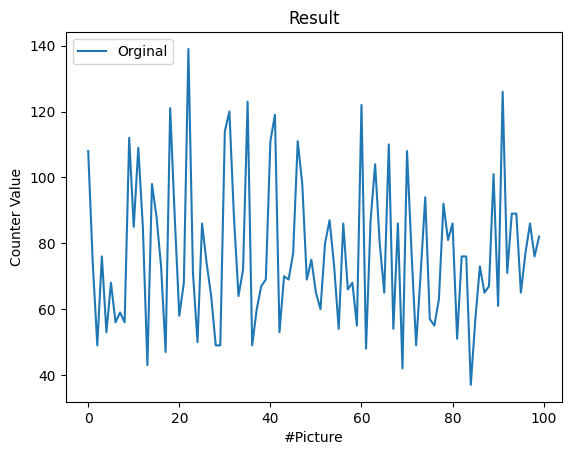

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

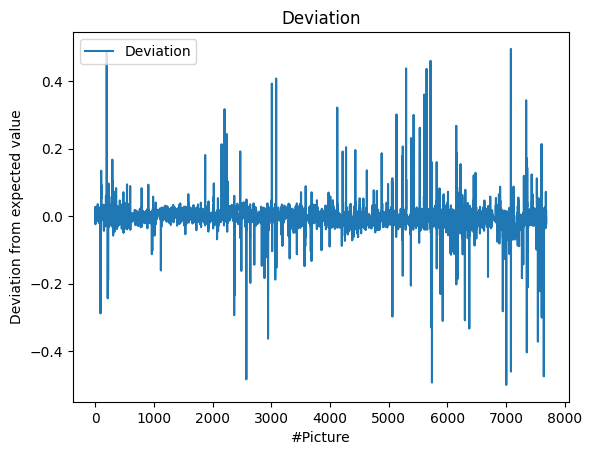

[-0.0027  0.0366 -0.4997  0.4959]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp4c75klq4\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp4c75klq4\assets


125772

In [15]:
from pathlib import Path
import tensorflow as tf

FileName = FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + "_q.tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpbeefza2x\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpbeefza2x\assets
C:\Users\Muell\anaconda3\envs\py39-td-opencv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


ana-cont_1210_s3_long_q.tflite


38544

In [2]:
FileName = "testq"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()


open(FileName + ".tflite", "wb").write(tflite_quant_model)

NameError: name 'model' is not defined